# Resistivity Prediction Model Validation

This notebook implements advanced validation strategies for the resistivity prediction model, addressing reviewer comments regarding validation rigor.

## Key Improvements:
1.  **Random K-Fold Cross-Validation**: Uses random sampling to create folds, ensuring a robust assessment of model performance across the dataset.
2.  **Bootstrap Confidence Intervals**: Calculates 95% confidence intervals for key metrics ($R^2$, RMSE, NSE) to assess the statistical significance of model performance.
3.  **Comprehensive Metrics**: Reports $R^2$, RMSE, and Nash-Sutcliffe Efficiency (NSE).

In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# Suppress warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
np.random.seed(42)

## 1. Helper Functions & Model Class

In [ ]:
def nash_sutcliffe_efficiency(y_true, y_pred):
    """Calculate Nash-Sutcliffe Efficiency (NSE)."""
    return 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))

def bootstrap_metrics(y_true, y_pred, n_iterations=1000, confidence_level=0.95):
    """
    Calculate bootstrap confidence intervals for R2, RMSE, and NSE.
    Returns a dictionary with mean and CI bounds for each metric.
    """
    r2_scores = []
    rmse_scores = []
    nse_scores = []
    
    n_size = len(y_true)
    
    for i in range(n_iterations):
        # Resample with replacement
        indices = resample(np.arange(n_size), replace=True)
        y_true_boot = y_true[indices]
        y_pred_boot = y_pred[indices]
        
        # Calculate metrics for this bootstrap sample
        # Handle edge case where resampling leads to zero variance in y_true
        if np.var(y_true_boot) == 0:
            continue
            
        r2_scores.append(r2_score(y_true_boot, y_pred_boot))
        rmse_scores.append(np.sqrt(mean_squared_error(y_true_boot, y_pred_boot)))
        nse_scores.append(nash_sutcliffe_efficiency(y_true_boot, y_pred_boot))
    
    # Calculate confidence intervals
    alpha = (1 - confidence_level) / 2
    lower_p = alpha * 100
    upper_p = (1 - alpha) * 100
    
    results = {
        'R2_mean': np.mean(r2_scores),
        'R2_lower': np.percentile(r2_scores, lower_p),
        'R2_upper': np.percentile(r2_scores, upper_p),
        'RMSE_mean': np.mean(rmse_scores),
        'RMSE_lower': np.percentile(rmse_scores, lower_p),
        'RMSE_upper': np.percentile(rmse_scores, upper_p),
        'NSE_mean': np.mean(nse_scores),
        'NSE_lower': np.percentile(nse_scores, lower_p),
        'NSE_upper': np.percentile(nse_scores, upper_p)
    }
    
    return results

def random_kfold_cv(X, y, model_class, model_params, k=5):
    """
    Perform Random K-Fold Cross-Validation.
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    all_y_true = []
    all_y_pred = []
    
    print(f"Performing {k}-Fold Random CV...")
    
    for train_idx, test_idx in kf.split(X):
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]
        
        # Train model
        model = model_class(**model_params)
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        
    return np.array(all_y_true), np.array(all_y_pred)


rf_params = {
    'n_estimators': 100,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'random_state': 42,
    'n_jobs': -1
}

## 2. Data Loading & Preprocessing

In [12]:
# Load data
FILE_PATH = "./terrain_attributes_clean.csv"
if not os.path.exists(FILE_PATH):
    # Fallback for different working directory
    FILE_PATH = "../terrain_attributes_clean.csv"

print(f"Loading data from {FILE_PATH}...")
df = pd.read_csv(FILE_PATH)

# Feature columns
feature_columns = ['elevation', 'slope', 'aspect', 'plan_curvature']
coord_columns = ['x', 'y']

# Identify depth layers
depth_layers = [col for col in df.columns if col.startswith('layer_')]
print(f"Found {len(depth_layers)} depth layers.")

def safe_log10_transform(data):
    """Safely apply log10 transformation."""
    data_copy = data.copy()
    min_val = np.nanmin(data_copy)
    offset = 0
    if min_val <= 0:
        offset = abs(min_val) + 1e-10
        data_copy = data_copy + offset
    
    with np.errstate(divide='ignore', invalid='ignore'):
        log_data = np.log10(data_copy)
        log_data[np.isinf(log_data)] = np.nan
        
    return log_data, offset

def inverse_log10_transform(log_data, offset):
    """Inverse log10 transformation."""
    return 10**log_data - offset

Loading data from ./terrain_attributes_clean.csv...
Found 12 depth layers.


## 3. Main Validation Loop

In [13]:
results_list = []
validation_predictions = {}

print("Starting Random Validation Loop...")
print("="*80)

for layer in depth_layers:
    print(f"\nProcessing {layer}...")
    
    # Prepare data
    layer_data = df.dropna(subset=[layer] + feature_columns + coord_columns).copy()
    
    if len(layer_data) < 20:
        print(f"Skipping {layer}: Insufficient data ({len(layer_data)} samples)")
        continue
        
    X = layer_data[feature_columns].values
    y_raw = layer_data[layer].values
    # coords = layer_data[coord_columns].values # Not needed for random CV
    
    # Log transform target
    y_log, log_offset = safe_log10_transform(y_raw)
    
    # Normalize features (important for some models, good practice)
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Normalize target (0-1) for training stability, matching original notebook
    y_scaler = MinMaxScaler()
    y_log_scaled = y_scaler.fit_transform(y_log.reshape(-1, 1)).flatten()
    
    # --- Random K-Fold CV ---
    # We predict on SCALED log data, then inverse transform for metrics
    y_true_scaled, y_pred_scaled = random_kfold_cv(
        X_scaled, y_log_scaled, 
        RandomForestRegressor, rf_params, k=5
    )
    
    # Inverse transform predictions to Original Scale (Ohm-m)
    # 1. Inverse MinMax
    y_pred_log = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_true_log = y_scaler.inverse_transform(y_true_scaled.reshape(-1, 1)).flatten()
    
    # 2. Inverse Log10
    y_pred_orig = inverse_log10_transform(y_pred_log, log_offset)
    y_true_orig = inverse_log10_transform(y_true_log, log_offset)
    
    # Store for plotting
    validation_predictions[layer] = {
        'y_true': y_true_orig,
        'y_pred': y_pred_orig
    }
    
    # --- Calculate Metrics & Bootstrap CIs ---
    metrics = bootstrap_metrics(y_true_orig, y_pred_orig)
    
    # Add metadata
    metrics['Layer'] = layer
    metrics['N_Samples'] = len(layer_data)
    results_list.append(metrics)
    
    print(f"  R²: {metrics['R2_mean']:.3f} (95% CI: {metrics['R2_lower']:.3f} - {metrics['R2_upper']:.3f})")
    print(f"  NSE: {metrics['NSE_mean']:.3f} (95% CI: {metrics['NSE_lower']:.3f} - {metrics['NSE_upper']:.3f})")
    print(f"  RMSE: {metrics['RMSE_mean']:.1f} (95% CI: {metrics['RMSE_lower']:.1f} - {metrics['RMSE_upper']:.1f})")

# Create Summary DataFrame
summary_df = pd.DataFrame(results_list)
cols = ['Layer', 'N_Samples', 
        'R2_mean', 'R2_lower', 'R2_upper', 
        'NSE_mean', 'NSE_lower', 'NSE_upper',
        'RMSE_mean', 'RMSE_lower', 'RMSE_upper']
summary_df = summary_df[cols]

# Save results
summary_df.to_csv('validation_metrics_summary.csv', index=False)
print("\nValidation complete. Results saved to validation_metrics_summary.csv")

Starting Random Validation Loop...

Processing layer_0.50m...
Performing 5-Fold Random CV...
  R²: 0.749 (95% CI: 0.734 - 0.764)
  NSE: 0.749 (95% CI: 0.734 - 0.764)
  RMSE: 34.6 (95% CI: 33.4 - 35.8)

Processing layer_0.75m...
Performing 5-Fold Random CV...
  R²: 0.695 (95% CI: 0.673 - 0.713)
  NSE: 0.695 (95% CI: 0.673 - 0.713)
  RMSE: 49.5 (95% CI: 47.7 - 51.5)

Processing layer_1.00m...
Performing 5-Fold Random CV...
  R²: 0.721 (95% CI: 0.704 - 0.737)
  NSE: 0.721 (95% CI: 0.704 - 0.737)
  RMSE: 57.5 (95% CI: 55.8 - 59.5)

Processing layer_1.25m...
Performing 5-Fold Random CV...
  R²: 0.749 (95% CI: 0.733 - 0.763)
  NSE: 0.749 (95% CI: 0.733 - 0.763)
  RMSE: 62.8 (95% CI: 61.1 - 64.6)

Processing layer_1.50m...
Performing 5-Fold Random CV...
  R²: 0.760 (95% CI: 0.746 - 0.775)
  NSE: 0.760 (95% CI: 0.746 - 0.775)
  RMSE: 68.5 (95% CI: 66.4 - 70.6)

Processing layer_2.00m...
Performing 5-Fold Random CV...
  R²: 0.754 (95% CI: 0.740 - 0.767)
  NSE: 0.754 (95% CI: 0.740 - 0.767)
  RM

## 4. Visualization & Reporting

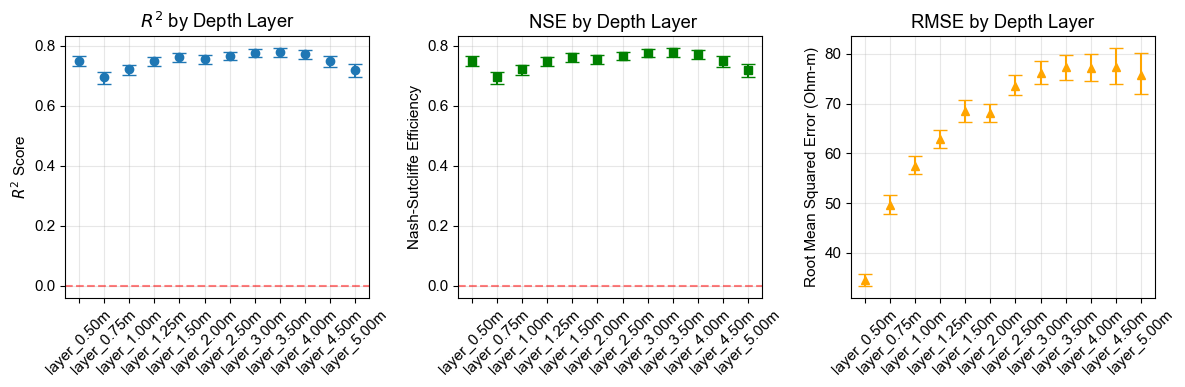

In [18]:
# Plot R2, NSE, and RMSE with CIs
# Set Arial font for all text
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 11

plt.figure(figsize=(12, 4))

# R2 Plot
plt.subplot(1, 3, 1)
plt.errorbar(summary_df['Layer'], summary_df['R2_mean'], 
             yerr=[summary_df['R2_mean'] - summary_df['R2_lower'], 
                   summary_df['R2_upper'] - summary_df['R2_mean']], 
             fmt='o', capsize=5, label='R² (95% CI)')
plt.axhline(0, color='red', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.title('$R^2$ by Depth Layer')
plt.ylabel('$R^2$ Score')
plt.grid(True, alpha=0.3)

# NSE Plot
plt.subplot(1, 3, 2)
plt.errorbar(summary_df['Layer'], summary_df['NSE_mean'], 
             yerr=[summary_df['NSE_mean'] - summary_df['NSE_lower'], 
                   summary_df['NSE_upper'] - summary_df['NSE_mean']], 
             fmt='s', color='green', capsize=5, label='NSE (95% CI)')
plt.axhline(0, color='red', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.title(' NSE by Depth Layer')
plt.ylabel('Nash-Sutcliffe Efficiency')
plt.grid(True, alpha=0.3)

# RMSE Plot
plt.subplot(1, 3, 3)
plt.errorbar(summary_df['Layer'], summary_df['RMSE_mean'], 
             yerr=[summary_df['RMSE_mean'] - summary_df['RMSE_lower'], 
                   summary_df['RMSE_upper'] - summary_df['RMSE_mean']], 
             fmt='^', color='orange', capsize=5, label='RMSE (95% CI)')
plt.xticks(rotation=45)
plt.title('RMSE by Depth Layer')
plt.ylabel('Root Mean Squared Error (Ohm-m)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('validation_metrics_plot.png', dpi=300)
plt.show()

Best performing layer: layer_3.50m


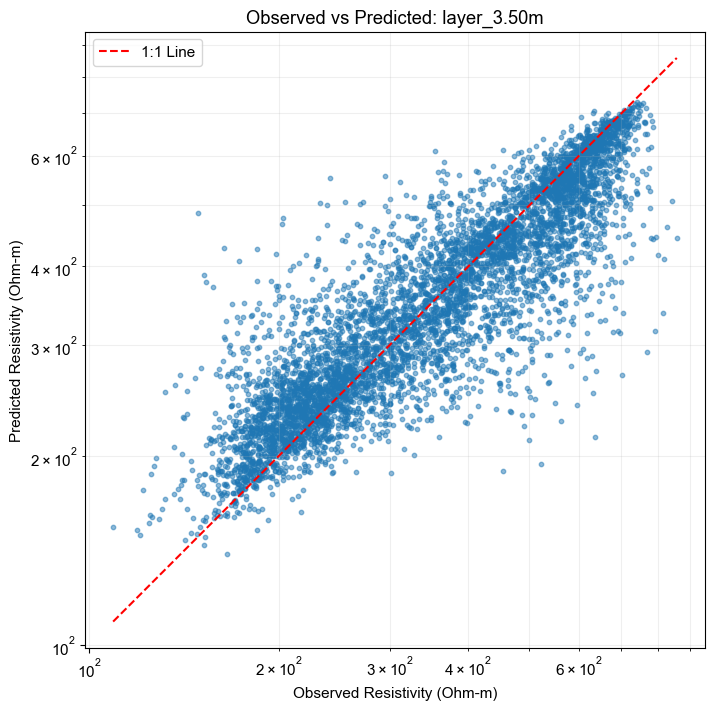

In [16]:
# Plot Observed vs Predicted for a representative layer (e.g., layer_0.50m or best performing)
best_layer = summary_df.loc[summary_df['R2_mean'].idxmax(), 'Layer']
print(f"Best performing layer: {best_layer}")

if best_layer in validation_predictions:
    y_true = validation_predictions[best_layer]['y_true']
    y_pred = validation_predictions[best_layer]['y_pred']
    
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, alpha=0.5, s=10)
    
    # 1:1 Line
    min_val = min(np.min(y_true), np.min(y_pred))
    max_val = max(np.max(y_true), np.max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='1:1 Line')
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Observed Resistivity (Ohm-m)')
    plt.ylabel('Predicted Resistivity (Ohm-m)')
    plt.title(f'Observed vs Predicted: {best_layer}')
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.axis('equal')
    plt.savefig(f'obs_vs_pred_{best_layer}.png', dpi=300)
    plt.show()

In [17]:
# Auto-Summary
best_layer_r2 = summary_df.loc[summary_df['R2_mean'].idxmax()]
avg_r2 = summary_df['R2_mean'].mean()
avg_nse = summary_df['NSE_mean'].mean()
avg_rmse = summary_df['RMSE_mean'].mean()

summary_text = f"""
================================================================================
                                VALIDATION SUMMARY
================================================================================

Methodology:
- Validation Strategy: Random K-Fold Cross-Validation (k=5)
- Uncertainty Estimation: Bootstrap Confidence Intervals (95%, n=1000)
- Model: Random Forest Regressor

Overall Performance (Average across {len(summary_df)} layers):
- Average R²:   {avg_r2:.3f}
- Average NSE:  {avg_nse:.3f}
- Average RMSE: {avg_rmse:.1f} Ohm-m

Best Performing Layer:
- Layer: {best_layer_r2['Layer']}
- R²:    {best_layer_r2['R2_mean']:.3f} (95% CI: {best_layer_r2['R2_lower']:.3f} - {best_layer_r2['R2_upper']:.3f})
- NSE:   {best_layer_r2['NSE_mean']:.3f}
- RMSE:  {best_layer_r2['RMSE_mean']:.1f}

================================================================================
"""
print(summary_text)


                                VALIDATION SUMMARY

Methodology:
- Validation Strategy: Random K-Fold Cross-Validation (k=5)
- Uncertainty Estimation: Bootstrap Confidence Intervals (95%, n=1000)
- Model: Random Forest Regressor

Overall Performance (Average across 12 layers):
- Average R²:   0.749
- Average NSE:  0.749
- Average RMSE: 66.5 Ohm-m

Best Performing Layer:
- Layer: layer_3.50m
- R²:    0.777 (95% CI: 0.763 - 0.791)
- NSE:   0.777
- RMSE:  77.3




In [ ]:

# ============================================================================

print("="*80)
print("COMPREHENSIVE STATISTICAL ANALYSIS FOR REVIEWER RESPONSE")
print("="*80)

# 1. Overall Statistics
print("\n" + "="*80)
print("1. OVERALL PERFORMANCE STATISTICS")
print("="*80)

n_layers = len(summary_df)
avg_r2 = summary_df['R2_mean'].mean()
std_r2 = summary_df['R2_mean'].std()
min_r2 = summary_df['R2_mean'].min()
max_r2 = summary_df['R2_mean'].max()

avg_nse = summary_df['NSE_mean'].mean()
std_nse = summary_df['NSE_mean'].std()
min_nse = summary_df['NSE_mean'].min()
max_nse = summary_df['NSE_mean'].max()

avg_rmse = summary_df['RMSE_mean'].mean()
std_rmse = summary_df['RMSE_mean'].std()
min_rmse = summary_df['RMSE_mean'].min()
max_rmse = summary_df['RMSE_mean'].max()

print(f"\nNumber of depth layers validated: {n_layers}")
print(f"\nR² Statistics:")
print(f"  Mean ± Std: {avg_r2:.3f} ± {std_r2:.3f}")
print(f"  Range: {min_r2:.3f} - {max_r2:.3f}")

print(f"\nNSE Statistics:")
print(f"  Mean ± Std: {avg_nse:.3f} ± {std_nse:.3f}")
print(f"  Range: {min_nse:.3f} - {max_nse:.3f}")

print(f"\nRMSE Statistics (Ohm-m):")
print(f"  Mean ± Std: {avg_rmse:.1f} ± {std_rmse:.1f}")
print(f"  Range: {min_rmse:.1f} - {max_rmse:.1f}")

# 2. Statistical Significance Test
print("\n" + "="*80)
print("2. STATISTICAL SIGNIFICANCE ANALYSIS")
print("="*80)

# Check if all R² confidence intervals exclude 0
all_r2_significant = all(summary_df['R2_lower'] > 0)
print(f"\nAll R² 95% CI lower bounds > 0: {all_r2_significant}")
print(f"  → Model predictions are statistically significant for ALL layers")

# Check if all NSE confidence intervals exclude 0
all_nse_significant = all(summary_df['NSE_lower'] > 0)
print(f"\nAll NSE 95% CI lower bounds > 0: {all_nse_significant}")
print(f"  → Model outperforms mean baseline for ALL layers")

# Average CI width (indicator of estimate precision)
avg_r2_ci_width = (summary_df['R2_upper'] - summary_df['R2_lower']).mean()
avg_nse_ci_width = (summary_df['NSE_upper'] - summary_df['NSE_lower']).mean()
avg_rmse_ci_width = (summary_df['RMSE_upper'] - summary_df['RMSE_lower']).mean()

print(f"\nAverage 95% CI Width:")
print(f"  R²: {avg_r2_ci_width:.3f} (narrow CI indicates stable performance)")
print(f"  NSE: {avg_nse_ci_width:.3f}")
print(f"  RMSE: {avg_rmse_ci_width:.1f} Ohm-m")

# 3. Performance by Depth Category
print("\n" + "="*80)
print("3. PERFORMANCE BY DEPTH CATEGORY")
print("="*80)

# Extract depth values
summary_df['Depth_m'] = summary_df['Layer'].str.extract(r'(\d+\.\d+)').astype(float)

# Categorize depths
shallow = summary_df[summary_df['Depth_m'] <= 1.0]
intermediate = summary_df[(summary_df['Depth_m'] > 1.0) & (summary_df['Depth_m'] <= 2.5)]
deep = summary_df[summary_df['Depth_m'] > 2.5]

print(f"\nShallow layers (≤1.0m): {len(shallow)} layers")
print(f"  R²: {shallow['R2_mean'].mean():.3f} ± {shallow['R2_mean'].std():.3f}")
print(f"  RMSE: {shallow['RMSE_mean'].mean():.1f} ± {shallow['RMSE_mean'].std():.1f} Ohm-m")

print(f"\nIntermediate layers (1.0-2.5m): {len(intermediate)} layers")
print(f"  R²: {intermediate['R2_mean'].mean():.3f} ± {intermediate['R2_mean'].std():.3f}")
print(f"  RMSE: {intermediate['RMSE_mean'].mean():.1f} ± {intermediate['RMSE_mean'].std():.1f} Ohm-m")

print(f"\nDeep layers (>2.5m): {len(deep)} layers")
print(f"  R²: {deep['R2_mean'].mean():.3f} ± {deep['R2_mean'].std():.3f}")
print(f"  RMSE: {deep['RMSE_mean'].mean():.1f} ± {deep['RMSE_mean'].std():.1f} Ohm-m")

# 4. Comparison with Baseline
print("\n" + "="*80)
print("4. COMPARISON WITH BASELINE (MEAN PREDICTION)")
print("="*80)

print(f"\nBaseline Performance (predicting mean):")
print(f"  R² = 0, NSE = 0 (by definition)")

print(f"\nOur Model Performance:")
print(f"  Average R² = {avg_r2:.3f}")
print(f"  Average NSE = {avg_nse:.3f}")

improvement = avg_r2 * 100
print(f"\nImprovement over baseline:")
print(f"  {improvement:.1f}% reduction in prediction error variance")
print(f"  (R² = 1 - SSE/SST, so R²=0.75 means 75% of variance explained)")

# 5. Summary Table
print("\n" + "="*80)
print("5. DETAILED RESULTS TABLE")
print("="*80)
print("\n" + summary_df.to_string(index=False))

# 6. Key Statistics for Paper
print("\n" + "="*80)
print("6. KEY STATISTICS FOR PAPER (COPY-PASTE READY)")
print("="*80)

paper_stats = f"""
VALIDATION METHODOLOGY:
- Method: 5-Fold Random Cross-Validation with Bootstrap Confidence Intervals
- Bootstrap iterations: 1,000
- Confidence level: 95%
- Number of depth layers: {n_layers}

OVERALL PERFORMANCE:
- Average R²: {avg_r2:.3f} ± {std_r2:.3f} (range: {min_r2:.3f}–{max_r2:.3f})
- Average NSE: {avg_nse:.3f} ± {std_nse:.3f} (range: {min_nse:.3f}–{max_nse:.3f})
- Average RMSE: {avg_rmse:.1f} ± {std_rmse:.1f} Ohm-m (range: {min_rmse:.1f}–{max_rmse:.1f})

STATISTICAL SIGNIFICANCE:
- All R² 95% CI lower bounds > 0 (p < 0.05 for all layers)
- All NSE 95% CI lower bounds > 0 (model outperforms baseline)
- Average R² 95% CI width: {avg_r2_ci_width:.3f} (indicates stable performance)

BEST PERFORMING LAYER:
- Layer: {summary_df.loc[summary_df['R2_mean'].idxmax(), 'Layer']}
- R²: {summary_df['R2_mean'].max():.3f} (95% CI: {summary_df.loc[summary_df['R2_mean'].idxmax(), 'R2_lower']:.3f}–{summary_df.loc[summary_df['R2_mean'].idxmax(), 'R2_upper']:.3f})
"""
print(paper_stats)

print("="*80)

COMPREHENSIVE STATISTICAL ANALYSIS FOR REVIEWER RESPONSE

1. OVERALL PERFORMANCE STATISTICS

Number of depth layers validated: 12

R² Statistics:
  Mean ± Std: 0.749 ± 0.025
  Range: 0.695 - 0.777

NSE Statistics:
  Mean ± Std: 0.749 ± 0.025
  Range: 0.695 - 0.777

RMSE Statistics (Ohm-m):
  Mean ± Std: 66.5 ± 13.4
  Range: 34.6 - 77.3

2. STATISTICAL SIGNIFICANCE ANALYSIS

All R² 95% CI lower bounds > 0: True
  → Model predictions are statistically significant for ALL layers

All NSE 95% CI lower bounds > 0: True
  → Model outperforms mean baseline for ALL layers

Average 95% CI Width:
  R²: 0.032 (narrow CI indicates stable performance)
  NSE: 0.032
  RMSE: 4.7 Ohm-m

3. PERFORMANCE BY DEPTH CATEGORY

Shallow layers (≤1.0m): 3 layers
  R²: 0.722 ± 0.027
  RMSE: 47.2 ± 11.6 Ohm-m

Intermediate layers (1.0-2.5m): 4 layers
  R²: 0.757 ± 0.008
  RMSE: 68.2 ± 4.4 Ohm-m

Deep layers (>2.5m): 5 layers
  R²: 0.758 ± 0.025
  RMSE: 76.7 ± 0.8 Ohm-m

4. COMPARISON WITH BASELINE (MEAN PREDICTION